<a href="https://colab.research.google.com/github/BharathSShankar/DSA4212_Assignments/blob/bharath-exp/DSA4212_assignment_1_w_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSA4212 Assignment 1: Starter Kit

In [1]:
import numpy as np
## Progress bar
from tqdm.auto import tqdm
import pylab as plt
import copy
import time

In [2]:
if 'google.colab' in str(get_ipython()):
  print("All ok -- code is running on a Google Colab")
else:
    print("==="*15, " WARNING ","==="*15)
    print("For DSA4212 assignment 1, code needs to be run on a Google Colab with a single GPU")
    print("==="*15, " WARNING ","==="*15)



All ok -- code is running on a Google Colab


In [3]:
!nvidia-smi -L
!lscpu |grep 'Model name'
!free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-2242b175-f110-d2e3-ef41-da145241a4b5)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


# Connect to Google Drive & Load data

In [4]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%pwd

'/content'

In [6]:
# goto to data folder -- you may need to change this location
%cd /content/drive/MyDrive/DSA4212/Assignment1/

/content/drive/MyDrive/DSA4212/Assignment1


In [7]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few secs
data_train = np.load("assignment_1_train.npz")
data_val = np.load("assignment_1_val.npz")

X_train = data_train["img"].astype(np.float32) / 256.   # set pixel intensities to [0,1]
X_val = data_val["img"].astype(np.float32) / 256.
Y_train = data_train["label"].astype(int)
Y_val = data_val["label"].astype(int)

_,H,W,C = X_train.shape
print(f"Img Shape: {H}x{W}x{C}")

Img Shape: 128x128x3


In [8]:
# shuffle the train set
indices_shuffled = np.arange(len(X_train))
np.random.shuffle(indices_shuffled)
X_train = X_train[indices_shuffled]
Y_train = Y_train[indices_shuffled]

# shuffle the validation set
indices_shuffled = np.arange(len(X_val))
np.random.shuffle(indices_shuffled)
X_val = X_val[indices_shuffled]
Y_val = Y_val[indices_shuffled]

In [9]:
sz_train = X_train.size * X_train.itemsize / 2.**30
sz_val = X_val.size * X_train.itemsize / 2.**30

print(f"Training Set Size: {sz_train:2.2f} Go")
print(f"Validaton Set Size: {sz_val:2.2f} Go")

Training Set Size: 1.70 Go
Validaton Set Size: 0.71 Go


Text(0.5, 1.0, 'Pixel Intensity')

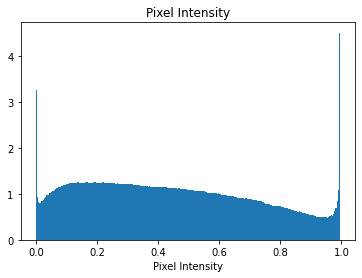

In [10]:
# histogram of pixel intensities
_ = plt.hist(X_train.ravel(), bins=256, density=True)
plt.xlabel("Pixel Intensity")
plt.title("Pixel Intensity")

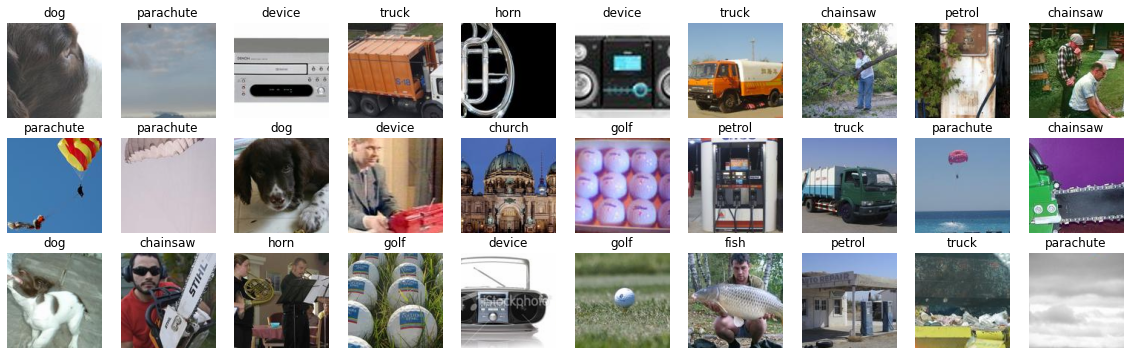

In [11]:
# train set:: sanity check
# plt a few random images in the trainset as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_train))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_train[index,:,:,:])
    plt.title(class_names[Y_train[index]])

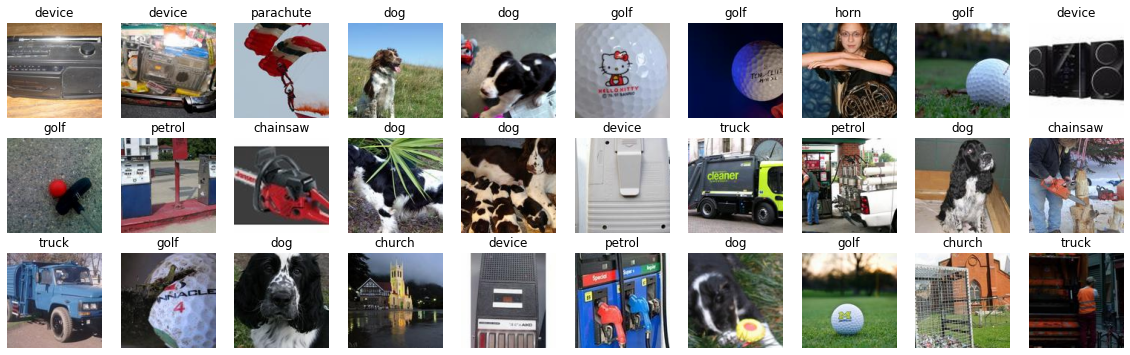

In [12]:
# validation set:: sanity check
# plt a few images as well as their label
plt.figure( figsize=(10*2,3*2) )
for k in range(3*10):
    index = np.random.randint(low=0, high=len(X_val))
    plt.subplot(3,10,k+1)
    plt.axis("off")
    plt.imshow(X_val[index,:,:,:])
    plt.title(class_names[Y_val[index]])

In [13]:
# load FLAX and install it if not installed already
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

import flax
from flax import linen as nn

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [14]:
import jax
import jax.numpy as jnp
from typing import Any, Sequence

try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [15]:
class LayerNorm(nn.Module):
    """
    input:
    ======
     x: tensor with D channels of dimension (B,H,W,D)
     
    output:
    ======
     x_normalized: tensor with D channels of dimension (B,H,W,D)
     
     
    Description:
    ===========
    for each each element `i` and each dimension `d`,
    normalize the 2D array x[i,:,:,d] by substracting its mean and divide by its standard deviation
       x_normalized[i,:,:,d] = (x[i,:,:,d] - mean) / stdev
    """
    @nn.compact
    def __call__(self, inputs):
        eps = 10**-3
        mean = jnp.expand_dims(jnp.mean(inputs, axis=(1,2)), axis=(1,2))
        std = jnp.expand_dims(jnp.std(inputs, axis=(1,2)), axis=(1,2))
        return (inputs - mean) / (eps + std)


In [16]:
class ResLayerSE(nn.Module):
    feature_dim: int

    @nn.compact
    def __call__(self, x):
        rc = x

        x = nn.Conv(features = self.feature_dim // 4 , kernel_size = (3, 3), strides = 2, padding = "SAME")(x)
        x = nn.elu(x)
        x = LayerNorm()(x)

        x = nn.Conv(features = self.feature_dim, kernel_size = (3, 3), strides = 2, padding = "SAME")(x)
        x = nn.elu(x)
        x = LayerNorm()(x)


        batch, _, _, channels = x.shape

        sf = x.mean(axis = (1, 2))
        sf = nn.relu(nn.Dense(self.feature_dim//4)(sf))
        sf = nn.sigmoid(nn.Dense(self.feature_dim)(sf))
        sf = jnp.reshape(sf, (batch, 1, 1, channels))
        sf = jnp.broadcast_to(sf, x.shape)

        rc = nn.Conv(features = self.feature_dim, kernel_size = (3, 3), strides = 4, padding = "SAME")(rc)

        return x + rc*sf

In [17]:
class SimpleCNN(nn.Module):
    """ a simple convolutional neural network """
    n_filters: Sequence[int]  # sequence -- number of CNN filters in each layer
    n_class: int              # number of possible classes
    
    @nn.compact
    def __call__(self, x, training = True):
        """
        inputs:
        ======
         inputs: batch of images of dimension (X,H,W,3)

        outputs:
        ======
         probas: predictive probability vector
        """
        
        # convolutional layers + normalization
        for i, feat_dim in enumerate(self.n_filters):
            x = nn.Conv(features=feat_dim, kernel_size=(3,3), strides = 2, padding='SAME', name=f'layers_{i}_1')(x)
            x = LayerNorm()(x)
            x = nn.selu(x)
            x = nn.Dropout(rate = 0.1, deterministic = not training)(x)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        # pooling -- average across the dimension (1,2)
        x = x.reshape((x.shape[0], -1))
        
        # last dense layer
        x = nn.Dense(self.n_class)(x)
        
        probas = nn.log_softmax(x)
        
        #convert to proba
        
        return probas

In [18]:

# generate a random generator "key" that is used to initialize the net parameters
key = jax.random.PRNGKey(0)
net = SimpleCNN(n_filters=[32, 64, 128], n_class = 10)

# to initialize the network, one needs to propagate some data through it
# and provide with a RNG key
key, key_, dropout_key = jax.random.split(key, num = 3)
batch_size = 32 
batch_of_images = X_train[:batch_size,:,:,:]
params_init = net.init(key_, batch_of_images, training = False)

# count the number of parameters
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params_init))
print(f"Number of Neural Parameters: {param_count//1000}k")

Number of Neural Parameters: 98k


In [19]:
#@jax.jit
def loss(params, x, y, training = True):
  """ cross-entropy loss
  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred = net.apply(params, x, training, rngs = {"dropout":dropout_key})
  y_hot = jax.nn.one_hot(y, n_class)
  CEs = -jnp.sum(y_hot * pred, axis=1)
  return jnp.mean(CEs)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [20]:
#@jax.jit
def prediction_class(params, x, training = True):
  """ make a prediction """
  pred = net.apply(params, x, training, rngs = {"dropout":dropout_key})
  pred_class = jnp.argmax(pred, axis=1)
  return pred_class

@jax.jit
def accuracy(params, x, y):
  """
  compute the accuracy on a batch of images

  inputs:
  ======
   params: neural network weights
   x: (B,H,W,3) -- batch of images
   y: (B) -- labels
  """
  n_class = 10

  # compute Cross-Entropy
  pred_class = prediction_class(params, x)
  return jnp.mean(pred_class == y)

# generate the gradient function
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [21]:
niter = 2000
batch_size = 512

# let us randomize the weights again to start from scratch
params = copy.deepcopy(params_init)

exponential_decay_scheduler = optax.exponential_decay(init_value=0.01, transition_steps=niter,
                                                      decay_rate=0.9, transition_begin=int(niter*0.25),
                                                      staircase=False)

#define the ADAM optimizer
optimizer = optax.adam(learning_rate=0.01, eps = 0.001)

#generate the initial state of the optimizer
opt_state = optimizer.init(params)

In [22]:
try:
    import augmax
except:
    !pip install augmax
    import augmax

In [23]:
# put data to GPU
print(X_train.shape)
X_train_proc = X_train.astype(jnp.float32) 
X_train = jax.device_put(X_train_proc)
X_val = jax.device_put(X_val.astype(jnp.float32))
print(X_train.shape)

(9296, 128, 128, 3)
(9296, 128, 128, 3)


In [24]:
transform = augmax.Chain(
    #augmax.Normalize(),
    #augmax.Rotate(),
    #augmax.RandomCrop(108, 108),
    augmax.VerticalFlip(),
    augmax.HorizontalFlip(),
)

In [25]:
X_train[1]

Array([[[0.25      , 0.24609375, 0.26953125],
        [0.25390625, 0.24609375, 0.265625  ],
        [0.26171875, 0.2421875 , 0.265625  ],
        ...,
        [0.34765625, 0.34375   , 0.3359375 ],
        [0.359375  , 0.35546875, 0.34765625],
        [0.36328125, 0.359375  , 0.3515625 ]],

       [[0.25      , 0.24609375, 0.26953125],
        [0.25      , 0.24609375, 0.26953125],
        [0.25390625, 0.24609375, 0.265625  ],
        ...,
        [0.375     , 0.375     , 0.3671875 ],
        [0.36328125, 0.36328125, 0.35546875],
        [0.34375   , 0.34375   , 0.3359375 ]],

       [[0.25      , 0.24609375, 0.26953125],
        [0.25      , 0.24609375, 0.26953125],
        [0.25390625, 0.2421875 , 0.26953125],
        ...,
        [0.3671875 , 0.3671875 , 0.359375  ],
        [0.34375   , 0.34375   , 0.3359375 ],
        [0.30859375, 0.30859375, 0.30078125]],

       ...,

       [[0.33203125, 0.296875  , 0.30859375],
        [0.29296875, 0.2578125 , 0.26953125],
        [0.2890625 , 0

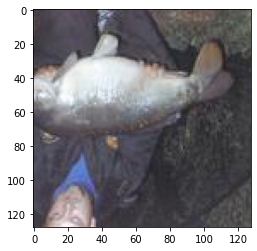

In [26]:
plt.imshow(transform(key_, X_train[1]))

In [ ]:
sub_rngs = jax.random.split(key_, batch_size)
vec_transform = jax.jit(jax.vmap(transform))
vec_normalise = jax.jit(jax.vmap(
    augmax.Chain(
        #augmax.Normalize(),
    )
))
val_dat = vec_normalise(sub_rngs, X_val[:batch_size])


# save the train loss
loss_train_history = []
loss_train_history_time = []

# save the validation loss
loss_val_history = []
loss_val_history_time = []

# save accuracies
accuracies_history = []
accuracies_history_time = []

time_start = time.time()
for k in tqdm( range(niter) ):
  # create a batch
  indices = jnp.arange(k*batch_size, (k+1)*batch_size) % len(X_train)
  X_batch = X_train[indices]
  Y_batch = Y_train[indices]
  

  X_batch = vec_transform(sub_rngs, X_batch)

  # compute loss and gradients
  loss_train, grads = loss_value_and_grad(params, X_batch, Y_batch)
  time_elapsed = time.time() - time_start

  if k % 50 == 0:
    # compute the accuracy on a batch only (to save a bit of time)
    N = 512
    acc_val = 100*accuracy(params, X_val[:N], Y_val[:N])
    acc_train = 100*accuracy(params, X_train[:N], Y_train[:N])
    nb_epoch = float(k+1)*batch_size / len(X_train)
    accuracies_history.append([acc_train, acc_val])
    accuracies_history_time.append(time_elapsed)

    # also compute test loss
    loss_val = loss(params, val_dat, Y_val[:N], False)
    loss_val_history.append( loss_val )
    loss_val_history_time.append( time_elapsed )

    print(f"Time:{time_elapsed:3.1f}sec \t Epoch:{nb_epoch:2.1f} \t Loss [{loss_train:2.2f} / {loss_val:2.2f}] \t Accuracy Train/Valid: [{acc_train:2.2f}% / {acc_val:2.2f}%]")

  # generate the "update mechanism" and update the state of the optimizer
  updates, opt_state = optimizer.update(grads, opt_state, params)
  # apply the "update mechanism"
  params = optax.apply_updates(params, updates)

  #opt_state, params = do_update(grads, opt_state, params)
    
  # save the loss
  loss_train_history_time.append( time_elapsed )
  loss_train_history.append( loss_train.item() )

  0%|          | 0/2000 [00:00<?, ?it/s]

Time:5.5sec 	 Epoch:0.1 	 Loss [2.83 / 2.71] 	 Accuracy Train/Valid: [11.91% / 10.55%]
Time:17.5sec 	 Epoch:2.8 	 Loss [2.00 / 2.09] 	 Accuracy Train/Valid: [31.25% / 25.39%]
Time:20.9sec 	 Epoch:5.6 	 Loss [1.80 / 1.85] 	 Accuracy Train/Valid: [41.21% / 36.33%]
Time:24.3sec 	 Epoch:8.3 	 Loss [1.46 / 1.60] 	 Accuracy Train/Valid: [51.17% / 42.58%]
Time:27.7sec 	 Epoch:11.1 	 Loss [1.40 / 1.60] 	 Accuracy Train/Valid: [55.47% / 45.31%]
Time:31.4sec 	 Epoch:13.8 	 Loss [1.25 / 1.43] 	 Accuracy Train/Valid: [61.91% / 53.52%]
Time:34.8sec 	 Epoch:16.6 	 Loss [1.14 / 1.35] 	 Accuracy Train/Valid: [65.62% / 54.69%]
Time:38.1sec 	 Epoch:19.3 	 Loss [1.12 / 1.44] 	 Accuracy Train/Valid: [65.04% / 51.95%]
Time:41.5sec 	 Epoch:22.1 	 Loss [1.00 / 1.23] 	 Accuracy Train/Valid: [68.36% / 58.59%]
Time:45.2sec 	 Epoch:24.8 	 Loss [0.97 / 1.26] 	 Accuracy Train/Valid: [69.14% / 57.62%]
Time:48.6sec 	 Epoch:27.6 	 Loss [0.86 / 1.33] 	 Accuracy Train/Valid: [71.68% / 57.81%]
Time:52.0sec 	 Epoch:30.3 

In [ ]:
plt.plot(loss_train_history_time, loss_train_history, "b-", lw = 3, label="train")
plt.plot(loss_val_history_time, loss_val_history, "r-+", lw = 3, label="test")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("loss", fontsize=20)
plt.grid(True)
plt.legend()


In [ ]:
accuracies_history = np.array(accuracies_history)
plt.plot(accuracies_history_time, accuracies_history[:,0], "b-", lw = 3, label="train")
plt.plot(accuracies_history_time, accuracies_history[:,1], "r-+", lw = 3, label="test")
plt.xlabel("seconds", fontsize=20)
plt.ylabel("accuracy", fontsize=20)
plt.ylim(0,100)
plt.grid(True)
plt.legend()

In [ ]:
# final validation accuracy
pred_val = []
n_forward_pass = len(X_val) // batch_size
for k in tqdm(range(n_forward_pass)):
  pred_val.append( prediction_class(params, X_val[k*batch_size:(k+1)*batch_size]) )
pred_val.append( prediction_class(params, X_val[n_forward_pass*batch_size:]) )

pred_val = np.concatenate(pred_val)
acc_validation = 100*jnp.mean(pred_val == Y_val)
print( f"Final Validation Accuracy: {acc_validation:2.1f}%")